In [16]:
import numpy as np
import pandas as pd
import os

# signature_list = ['NK-IL18-IFNG', 'NK_activation', 'NFkB_pathway', 'IL-18_pathway']
signature_list = ['TIM1']
dataset_list = ['TCGA-COAD', 'TCGA-LUAD', 'TCGA-PAAD', 'TCGA-STAD']
for signature in signature_list:
    if signature == 'TIM1':
        signature_gene = ["HAVCR1"]
    for dataset in dataset_list:
        clinical_path = f'/sibcb1/bioinformatics/hongyuyang/dataset/Tres/3-5.B_analysis/{dataset}/clinical.tsv'
        gem_path = f'/sibcb1/bioinformatics/hongyuyang/dataset/Tres/3-5.B_analysis/{dataset}/gem.csv'
        outputdir = f'/sibcb1/bioinformatics/hongyuyang/dataset/Tres/3-5.B_analysis/{dataset}'
        
        gem_df = pd.read_csv(gem_path, index_col=0, header=0)
        clinical_data = pd.read_csv(clinical_path, index_col=0, header=0, delimiter='\t')
        clinical_data_filter = clinical_data[clinical_data['treatment_type'] == 'Pharmaceutical Therapy, NOS']
        survival_df = clinical_data_filter[['days_to_death', 'days_to_last_follow_up', 'vital_status']]
        
        def get_day_to_event(x):
            if x['vital_status'] == "Dead":
                return x['days_to_death']
            else:
                return x['days_to_last_follow_up']
        survival_df['days_to_event'] = survival_df.apply(lambda x: get_day_to_event(x), axis=1)
        survival_df['days_to_event'].replace('\'--', 0.0, inplace=True)
        survival_df['days_to_event'] = survival_df['days_to_event'].astype(float)
        
        def get_group(x):
            if x['vital_status'] == "Dead":
                return 1
            else:
                return 0
        survival_df['death'] = survival_df.apply(lambda x: get_group(x), axis=1)
        
        common_gene = gem_df.index.intersection(signature_gene)
        signature_mean = gem_df.loc[common_gene, :].mean()
        signature_high_sample = signature_mean[signature_mean > signature_mean.quantile(q=0.5)].index
        signature_low_sample = signature_mean[signature_mean < signature_mean.quantile(q=0.5)].index
            
        def get_group(x):
            if x in signature_high_sample:
                return "high"
            if x in signature_low_sample:
                return "low"
        survival_df['group'] = survival_df.index.map(lambda x: get_group(x))
        survival_df = survival_df[survival_df['group'].isin(['low', 'high'])]
        
        survival_df.to_csv(os.path.join(outputdir, f'{signature}.survival.csv'))
    print(f"{signature} process end.")

/var/tmp/ipykernel_59804/133841483.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_df['days_to_event'] = survival_df.apply(lambda x: get_day_to_event(x), axis=1)
/var/tmp/ipykernel_59804/133841483.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  survival_df['days_to_eve

TIM1 process end.


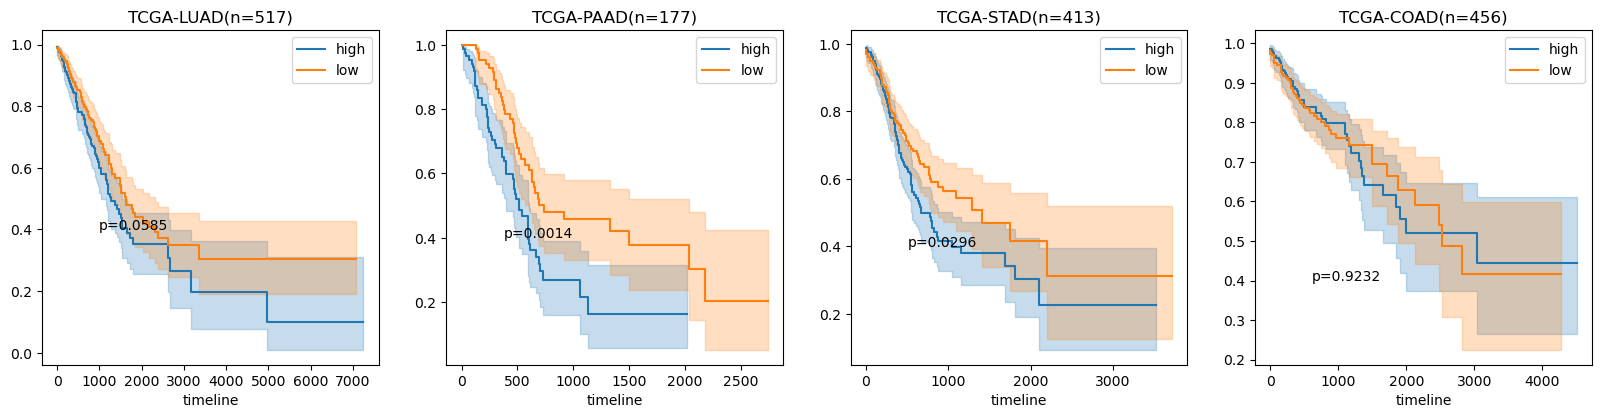

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# signature_list = ['NK-IL18-IFNG', 'NK_activation', 'NFkB_pathway', 'IL-18_pathway']
signature_list = ['TIM1']
dataset_list = ['TCGA-LUAD', 'TCGA-PAAD', 'TCGA-STAD', 'TCGA-COAD']
fig = plt.figure(figsize=(5 * len(dataset_list), 5 * len(dataset_list)))
gs = gridspec.GridSpec(nrows=len(dataset_list), ncols=len(dataset_list), width_ratios=[1] * len(dataset_list))
col, row = 0, 0
for row in range(len(dataset_list)):
    dataset = dataset_list[row]
    for col in range(len(signature_list)):
        signature = signature_list[col]
        ax = fig.add_subplot(gs[0, row])
        outputdir = f'/sibcb1/bioinformatics/hongyuyang/dataset/Tres/3-5.B_analysis/{dataset}'
        survival_path = os.path.join(outputdir, f'{signature}.survival.csv')
        survival_df = pd.read_csv(survival_path, index_col=0, header=0)
        
        kmf = KaplanMeierFitter() # KM初始化
        for group_name, group_data in survival_df.groupby('group'):
            kmf.fit(group_data["days_to_event"], group_data["death"], label=group_name)
            kmf.plot_survival_function()
                            
        flag = (survival_df['group'] == 'high')
        time = survival_df["days_to_event"]
        death = survival_df["death"]
        results = logrank_test(time[flag], time[~flag], death[flag], death[~flag], alpha=.99)
        ax.set_title(f"{dataset}(n={len(death)})")
        ax.text(max(time) / 4, 0.4, f'p={"{:.4f}".format(results.p_value)}', ha='center', fontsize=10)

In [33]:
import numpy as np
import pandas as pd
import os

celltype_list = ['CD8T', 'Macrophage', 'Neutrophils', 'NK', 'NK_act']
dataset_list = ["TCGA-BRCA", "TCGA-CESC", "TCGA-SKCM"]
for celltype in celltype_list:
    for dataset in dataset_list:
        correlation_path = f'/sibcb1/bioinformatics/hongyuyang/dataset/Tres/3-5.B_analysis/{dataset}/correlation/{celltype}.correlation.negative.csv'
        correlation_df = pd.read_csv(correlation_path, header=0, index_col=0)        
        clinical_path = f'/sibcb1/bioinformatics/hongyuyang/dataset/Tres/3-5.B_analysis/{dataset}/clinical.tsv'
        clinical_data = pd.read_csv(clinical_path, index_col=0, header=0, delimiter='\t')
        clinical_data_filter = clinical_data[clinical_data['treatment_type'] == 'Pharmaceutical Therapy, NOS']
        survival_df = clinical_data_filter[['days_to_death', 'days_to_last_follow_up', 'vital_status']]
        
        def get_day_to_event(x):
            if x['vital_status'] == "Dead":
                return x['days_to_death']
            else:
                return x['days_to_last_follow_up']
        survival_df['days_to_event'] = survival_df.apply(lambda x: get_day_to_event(x), axis=1)
        survival_df['days_to_event'].replace('\'--', 0.0, inplace=True)
        survival_df['days_to_event'] = survival_df['days_to_event'].astype(float)
        
        def get_group(x):
            if x['vital_status'] == "Dead":
                return 1
            else:
                return 0
        survival_df['death'] = survival_df.apply(lambda x: get_group(x), axis=1)

        correlation_high_sample = correlation_df[correlation_df > correlation_df.quantile(q=0.75)].dropna().index
        correlation_low_sample = correlation_df[correlation_df < correlation_df.quantile(q=0.25)].dropna().index
            
        def get_group(x):
            if x in correlation_high_sample:
                return "high"
            if x in correlation_low_sample:
                return "low"
        survival_df['group'] = survival_df.index.map(lambda x: get_group(x))
        survival_df = survival_df[survival_df['group'].isin(['low', 'high'])]

        outputdir = f'/sibcb1/bioinformatics/hongyuyang/dataset/Tres/3-5.B_analysis/{dataset}/survival'
        if not os.path.exists(outputdir): os.mkdir(outputdir)
        survival_df.to_csv(os.path.join(outputdir, f'{celltype}.survival.csv'))
    print(f"{celltype} process end.")

/var/tmp/ipykernel_160404/1929704617.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_df['days_to_event'] = survival_df.apply(lambda x: get_day_to_event(x), axis=1)
/var/tmp/ipykernel_160404/1929704617.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  survival_df['days_to

CD8T process end.


/var/tmp/ipykernel_160404/1929704617.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_df['days_to_event'] = survival_df.apply(lambda x: get_day_to_event(x), axis=1)
/var/tmp/ipykernel_160404/1929704617.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  survival_df['days_to

Macrophage process end.


/var/tmp/ipykernel_160404/1929704617.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_df['group'] = survival_df.index.map(lambda x: get_group(x))
/var/tmp/ipykernel_160404/1929704617.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_df['days_to_event'] = survival_df.apply(lambda x: get_day_to_event(x), axis=1)
/var/tmp/ipykernel_160404/1929704617.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
T

Neutrophils process end.
NK process end.


/var/tmp/ipykernel_160404/1929704617.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_df['group'] = survival_df.index.map(lambda x: get_group(x))
/var/tmp/ipykernel_160404/1929704617.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_df['days_to_event'] = survival_df.apply(lambda x: get_day_to_event(x), axis=1)
/var/tmp/ipykernel_160404/1929704617.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
T

NK_act process end.


/var/tmp/ipykernel_160404/1929704617.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_df['days_to_event'] = survival_df.apply(lambda x: get_day_to_event(x), axis=1)
/var/tmp/ipykernel_160404/1929704617.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  survival_df['days_to

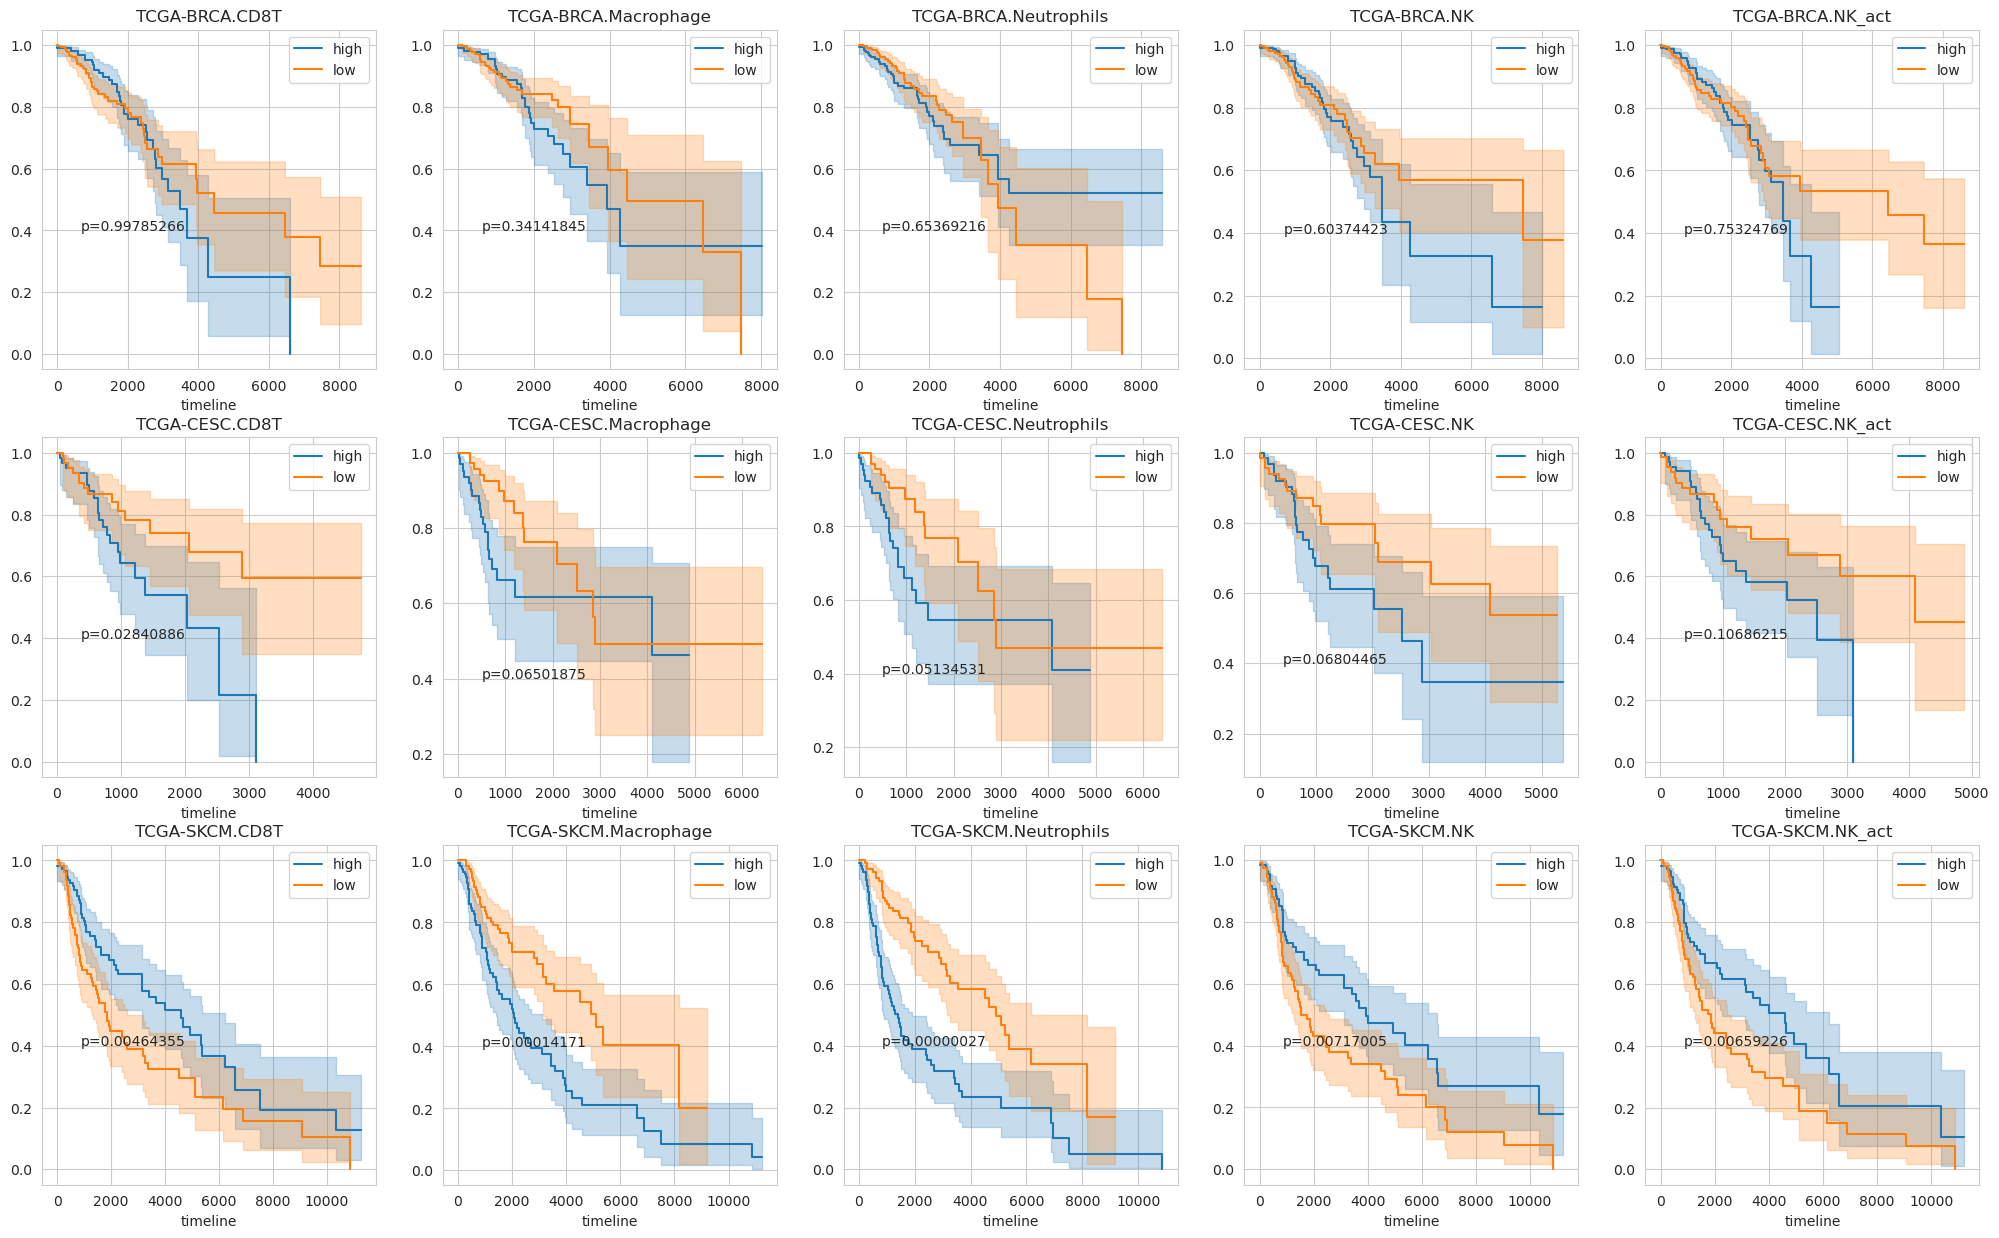

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

celltype_list = ['CD8T', 'Macrophage', 'Neutrophils', 'NK', 'NK_act']
dataset_list = ["TCGA-BRCA", "TCGA-CESC", "TCGA-SKCM"]

fig = plt.figure(figsize=(5 * len(celltype_list), 5 * len(dataset_list)))
gs = gridspec.GridSpec(nrows=len(dataset_list), ncols=len(celltype_list), width_ratios=[1] * len(celltype_list))
col, row = 0, 0
for row in range(len(dataset_list)):
    dataset = dataset_list[row]
    for col in range(len(celltype_list)):
        celltype = celltype_list[col]
        ax = fig.add_subplot(gs[row, col])
        outputdir = f'/sibcb1/bioinformatics/hongyuyang/dataset/Tres/3-5.B_analysis/{dataset}/survival'
        survival_path = os.path.join(outputdir, f'{celltype}.survival.csv')
        survival_df = pd.read_csv(survival_path, index_col=0, header=0)
        
        kmf = KaplanMeierFitter() # KM初始化
        for group_name, group_data in survival_df.groupby('group'):
            kmf.fit(group_data["days_to_event"], group_data["death"], label=group_name)
            kmf.plot_survival_function()
                            
        flag = (survival_df['group'] == 'high')
        time = survival_df["days_to_event"]
        death = survival_df["death"]
        results = logrank_test(time[flag], time[~flag], death[flag], death[~flag], alpha=.99)
        ax.set_title(f"{dataset}.{celltype}")
        ax.text(max(time) / 4, 0.4, f'p={"{:.8f}".format(results.p_value)}', ha='center', fontsize=10)  